# Modeling rectangle overlaps with differentiable constraints
This notebook discusses techniques to deal with the rectangle overlapping problem in non-convex optimization. The problem we are discussing is the following:

> Given two rectangles, $R_1$ and $R_2$, defined by their centers, $(x_1,y_1)$ and $(x_2,y_2)$, and their widths and heights, $(w_1,h_1)$ and $(w_2,h_2)$, we want to define mathematical constraints on these variables that guarantee that the two rectangles do not overlap.

Ideally, we would like these contraints to be differentiable.

### Interval overlap
Let us consider the problem of interval overlap, i.e., given two intervals, $I_1$ and $I_2$, determined by their centers, $x_1$ and $x_2$, and their widths, $w_1$ and $w_2$, let us define a constraint that guarantees that the two intervals do not overlap.

The intervals will not overlap when the distance between the two centers is larger than or equal to the sum of the half-width of the intervals, i.e.,

\begin{align}
|x_1-x_2| \geq \frac{1}{2}(w_1+w_2).
\end{align}

By squaring both sides, we can derive an equivalent (differentiable) constraint:

\begin{align}
(x_1-x_2)^2 - \frac{1}{4}(w_1+w_2)^2 \geq 0.
\end{align}

### Rectangle overlap
A rectangle is defined by two intervals, horizontal (width) and vertical (height). Two rectangles overlap if their horizontal and vertical intervals overlap. The fact that two rectangles do not overlap can be represented by a disjunction: either the horizontal intervals or the vertical intervals do not overlap, i.e.,

\begin{align}
(x_1-x_2)^2 - \frac{1}{4}(w_1+w_2)^2 \geq 0 \quad \vee \quad (y_1-y_2)^2 - \frac{1}{4}(h_1+h_2)^2 \geq 0.
\end{align}

Equivalently,

\begin{align}
\max\left((x_1-x_2)^2 - \frac{1}{4}(w_1+w_2)^2, (y_1-y_2)^2 - \frac{1}{4}(h_1+h_2)^2\right) \geq 0.
\end{align}

Unfortunately, neither the disjunction nor the $\max$ function are differentiable.

### A differentiable function to approximate the maximum of two numbers

The function $f(a,b)=\frac{1}{2}(a+b+|a-b|)$ computes the maximum of two numbers. We can rewrite the function as 

\begin{align}
f(a,b)=\frac{1}{2}(a+b+\sqrt{(a-b)^2}).
\end{align}

Unfortunately, this function is not differentiable at the point $a=b$. At the expense of a small error, the function can be made differentiable by adding a small $\tau>0$ to the formula as follows:

\begin{align}
f_\tau(a,b)=\frac{1}{2}(a+b+\sqrt{(a-b)^2+4\tau^2}).
\end{align}

With the previous approximation, $\tau$ is the maximum value of $|\max(a,b)-f_\tau(a,b)|$. The maximum error is produced when $a=b$. You can easily check that $f_\tau(a,a) = a+\tau$.

See: Volker Maag, Martin Berger, Anton Winterfeld and Karl-Heinz Küfer, A novel non-linear approach to minimal area rectangular packing, *Annals of Operations Research* 179, 243–260 (2010).

In [401]:
#type: ignore
%matplotlib inline
import math
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.colors as clr
import matplotlib.pyplot as plt
print(plt.style.available)
plt.style.use('seaborn-v0_8-poster')
mpl.rcParams['legend.fontsize'] = 10

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [402]:
def set_fontsize(ax, size, three_dim=False):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    if three_dim:
        ax.zaxis.label.set_fontsize(size)
        ax.zaxis.set_tick_params(labelsize=size)

Let us define the function $f_\tau(a,b)$ that approximates $\max(a,b)$.

In [403]:
def fmax(a, b, tau):
    return 0.5*(a + b + math.sqrt((a-b)**2+4*tau*tau))

Let us test the function with few pairs of values. Notice that the maximum error is produced when $a=b$.

In [404]:
tau = 10**(-3)
pairs = [(3, 5), (-2, 4), (1, 1), (1, -1), (0, 0), (0, -0.1), (-2, -1), (-4, -4)]
for a, b in pairs:
    print("a=", a, ", b=", b, ", max=", fmax(a, b, tau), sep='')

a=3, b=5, max=5.000000499999875
a=-2, b=4, max=4.000000166666662
a=1, b=1, max=1.001
a=1, b=-1, max=1.000000499999875
a=0, b=0, max=0.001
a=0, b=-0.1, max=9.999000199954755e-06
a=-2, b=-1, max=-0.9999990000010001
a=-4, b=-4, max=-3.999


Let us now plot $f_\tau(a,0)$ for different values of a and $\tau$.

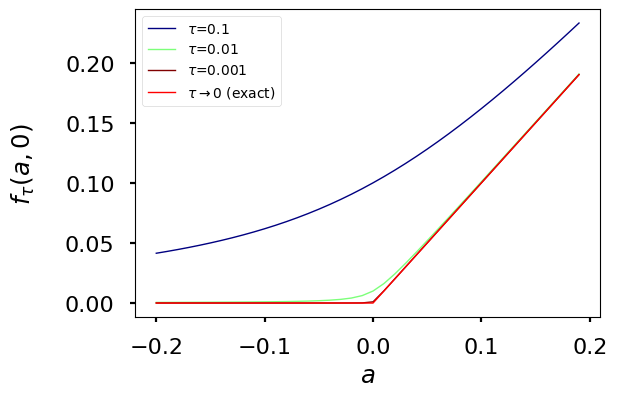

In [405]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()
tau_values = [0.1, 0.01, 0.001]
a_values = np.arange(-0.2,0.2,0.01)
colors = plt.cm.jet(np.linspace(0,1,len(tau_values)))
for i,t in enumerate(tau_values):
    f = [fmax(a,0,t) for a in a_values]
    plt.plot(a_values, f, color=colors[i], label=fr'$\tau$={t}', linewidth=1)
f = [max(a,0) for a in a_values]
plt.plot(a_values, f, color="red", label=r"$\tau\rightarrow 0$ (exact)", linewidth=1)
plt.legend(loc="upper left")
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$f_\tau(a,0)$', labelpad=20)
plt.show()

Let us now define the overlap function that receives the centers of two intervals, $x_1$ and $x_2$, and their widths, $w_1$ and $w_2$. The intervals overlap if the function returns a negative value.

In [406]:
def overlap(x1, x2, w1, w2):
    return (x1-x2)**2 - 0.25*((w1+w2)**2)

Let us test the function by taking one interval with center $x_1=10$ and width $w_1=6$. Let us consider a second interval with width $w_2=4$. Let us see the value of the overlap function for different values of $x_2$.

Notice that the function is negative (the intervals overlap) for the values $x_2\in[5,15]$. 

In [407]:
x1, w1 = 10, 6
x2 = np.arange(0,20,0.1)
w2 = 4
y = overlap(x1, x2, w1, w2)

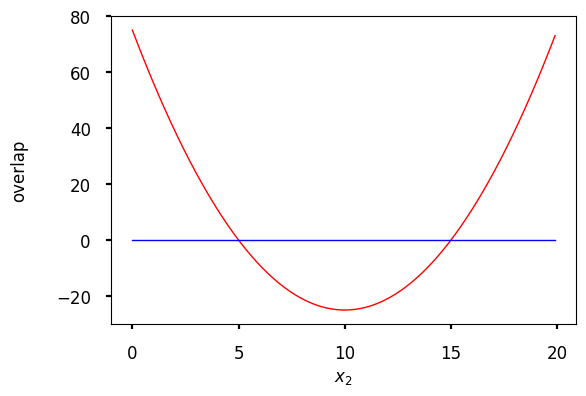

In [408]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()
plt.plot(x2, y , color='red', linewidth=1)
plt.plot(x2, [0]*len(x2), color='blue', linewidth=1)
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xlabel(r'$x_2$')
ax.set_ylabel('overlap', labelpad=20)
set_fontsize(ax, 12)
plt.show()

## Visualizing the overlapping of rectangles

First of all, some auxiliary functions (you can skip the details).

Here is a function to plot a rectangle with center $(x,y)$, width $w$ and height $h$. Plotting the center is optional.

In [409]:
def plot_rectangle(plt, x, y, w, h, color, plot_center=True, linewidth=1):
    xmin, xmax = x-w/2, x+w/2
    ymin, ymax = y-h/2, y+h/2
    
    plt.plot([xmin, xmax], [ymin, ymin], color, linewidth=linewidth)
    plt.plot([xmin, xmax], [ymax, ymax], color, linewidth=linewidth)
    plt.plot([xmin, xmin], [ymin, ymax], color, linewidth=linewidth)
    plt.plot([xmax, xmax], [ymin, ymax], color, linewidth=linewidth)
    if plot_center:
        plt.plot(x, y, 'o', color=color, markersize=5)


Here is a function that selects the points in which zz[i][j] is close to zero (i.e., the border of the overlap function).

The function receives the vectors $x$ and $y$ and the matrix $zz$. The vectors contain the coordinates corresponding to the rows and columns of the matrix.

The function returns a list of pairs $(x,y)$ that are close to the border.

In [410]:
def select_border(x, y, zz):
    zz_pos = np.array([[abs(j) for j in row] for row in zz])
    nrows = len(zz)
    ncols = len(zz[0])
    
    points = []

    for i in range(nrows):
        if min(zz[i]) > 0:
            continue
        first, second = 0, 0
        for j in range(1, ncols):
            if zz_pos[i][j] < zz_pos[i][second]:
                second = j
                if zz_pos[i][second] < zz_pos[i][first]:
                    first, second = second, first
        points.append((x[i], y[first]))
        points.append((x[i], y[second]))
    
    for j in range(ncols):
        if min((zz[i][j] for i in range(nrows))) > 0:
            continue
        first, second = 0, 0
        for i in range(1, nrows):
            if zz_pos[i][j] < zz_pos[second][j]:
                second = i
                if zz_pos[second][j] < zz_pos[first][j]:
                    first, second = second, first
        points.append((x[first], y[j]))
        points.append((x[second], y[j]))
    
    return points

Let us now generate a 3D plot of the overlap function between a pair of rectangles. The first rectangle will be fixed with center $(x_1, y_1)$, width $w_1$ and height $h_1$. The second rectangle, with $w_2=2$ and $h_2=2$, will be moved around the first rectangle. See the 3D plot and how the overlap function evolves across the plane. A value $\tau$ is also defined to approximate the max function.

In [411]:
# First rectangle
x1, y1 = 10, 10
w1, h1 = 6, 4

# Second rectangle (the x2 and y2 coordinates will be changed across the plane)
w2, h2 = 4, 5

In [412]:
def plot_regions(x1, y1, w1, h1, w2, h2, tau):
    samples = 1000
    xmargin = w1/2 + 1.3*w2
    ymargin = h1/2 + 1.3*h2

    x = np.linspace(x1-xmargin, x1+xmargin, num=samples)
    y = np.linspace(y1-ymargin, y1+ymargin, num=samples)
    zz = np.array([[fmax(overlap(x1, x2, w1, w2), overlap(y1, y2, h1, h2), tau)
                    for y2 in y] for x2 in x])

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = plt.cm.cividis
    cs = plt.imshow(zz, cmap=cmap,
                    extent=[np.min(x), np.max(x), np.min(y), np.max(y)])

    # Axes and legends
    ax.set_xlabel(r'$x_2$', labelpad=12)
    ax.set_ylabel(r'$y_2$', labelpad=12)
    fig.colorbar(cs, ax=ax)
    set_fontsize(ax, 10)

    plt.title(r'$\tau=$'+str(tau))
    # The reference rectangle
    plot_rectangle(plt, x1, y1, w1, h1, 'aqua', True, 2)

    # Rectangle without overlap (true negative)
    plot_rectangle(plt, x1-0.25*w1, y1+0.5*h1+0.6*h2, w2, h2, 'lime', True)

    # Rectangle with overlap (true positive)
    plot_rectangle(plt, x1+0.25*w1, y1-0.5*h1-0.2*h2, w2, h2, 'r', True)

    # Limits of the legal rectangles without overlap
    plot_rectangle(plt, x1, y1, w1+w2, h1+h2, 'w', False, 2)

    # The border of false positives
    xborder, yborder = zip(*select_border(x, y, zz))
    plt.plot(xborder, yborder,'o', color='cyan', markersize=1)

    # Let us now draw a false positive rectangle
    xmin = x1 - 0.5*(w1+w2)
    ymin = y1 - 0.5*(h1+h2)
    prev_diff = 1000
    prev_i = 0
    for i in range(1, len(xborder)):
        if yborder[i] >= y1:
            continue
        x_off = xborder[i] - xmin
        y_off = yborder[i] - ymin
        diff = abs(x_off-y_off)
        if diff > prev_diff:
            break
        prev_i = i
        prev_diff = diff
        
    x_false = (xmin + 2*xborder[prev_i])/3
    y_false = (ymin + yborder[prev_i])/2
    plot_rectangle(plt, x_false, y_false, w2, h2, 'yellow', True)

We now plot the overlapping regions for different values of $\tau$.

The interpretation of the plot is as follows:
* The inner rectangle (blue) is the fixed reference rectangle with center $(x_1,y_1)$, width $w_1$ and height $h_1$.
* The thin rectangles are instances of the floating rectangle with width $w_2$ and height $h_2$.
* The white rectangle defines the border between overlapping and non-overlapping floating rectangles. Any center $(x_2,y_2)$ inside the rectangle corresponds to an overlapping rectangle.
* The blue oval curve defines the region of rectangles that are considered as overlapping when using the approximation of the max function.
* The points outside the oval region are considered as non-overlapping.
* The green rectangle is a true positive (non-overlapping).
* The red rectangle is a true negative (overlapping).
* The yellow rectangle is a false positive (overlapping, but detected as non-overlapping). 

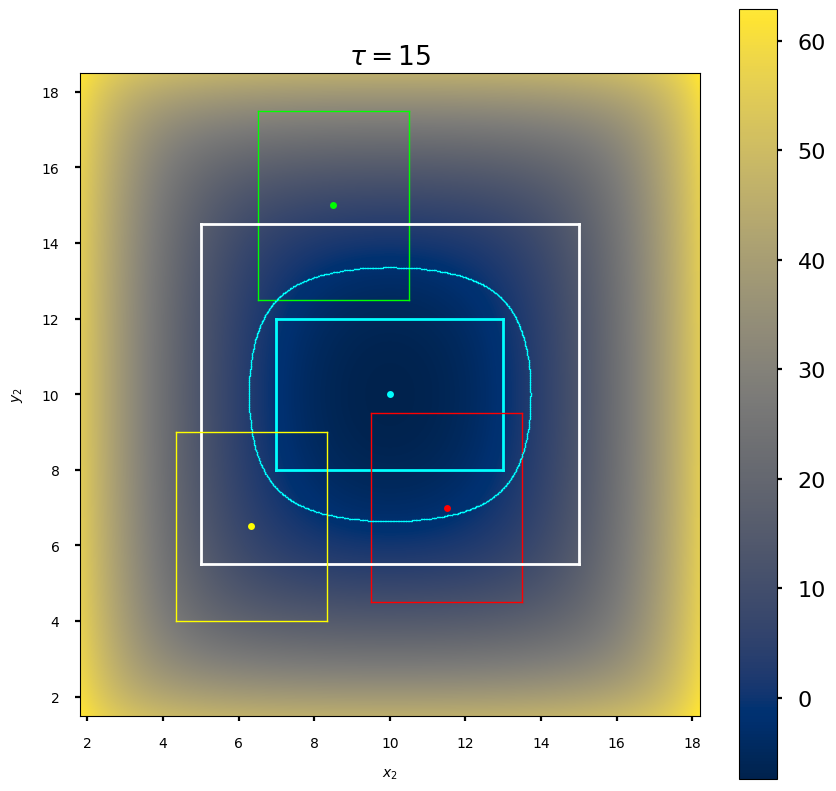

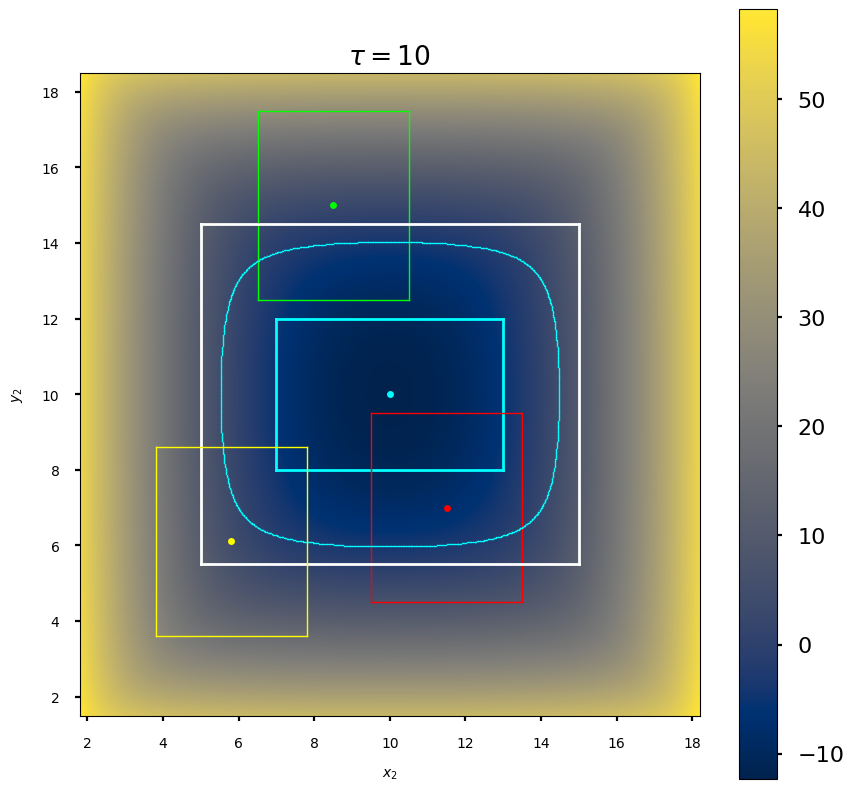

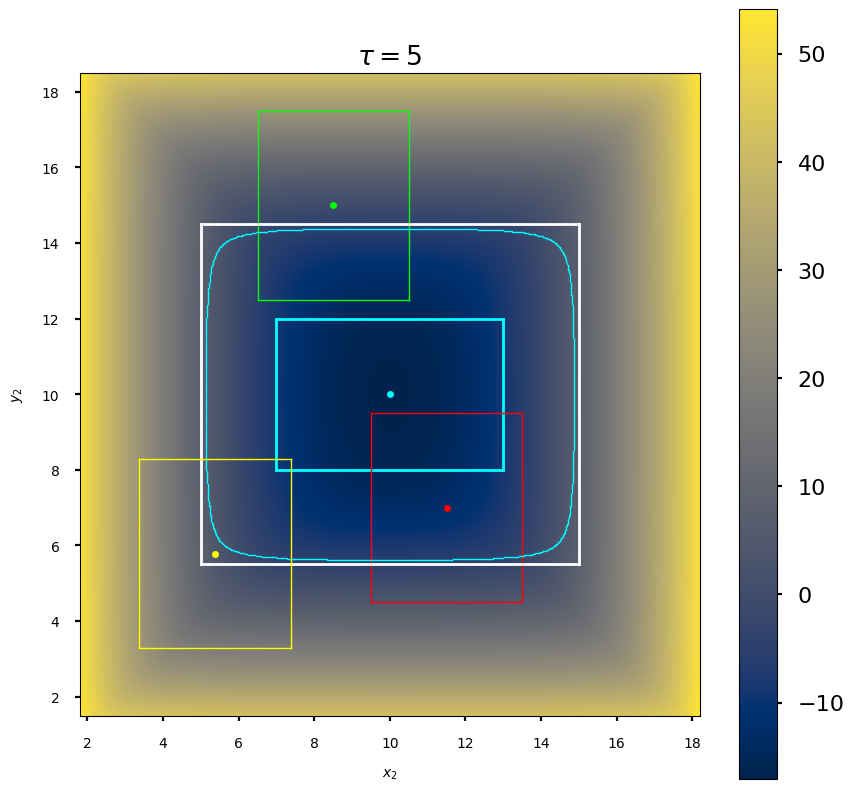

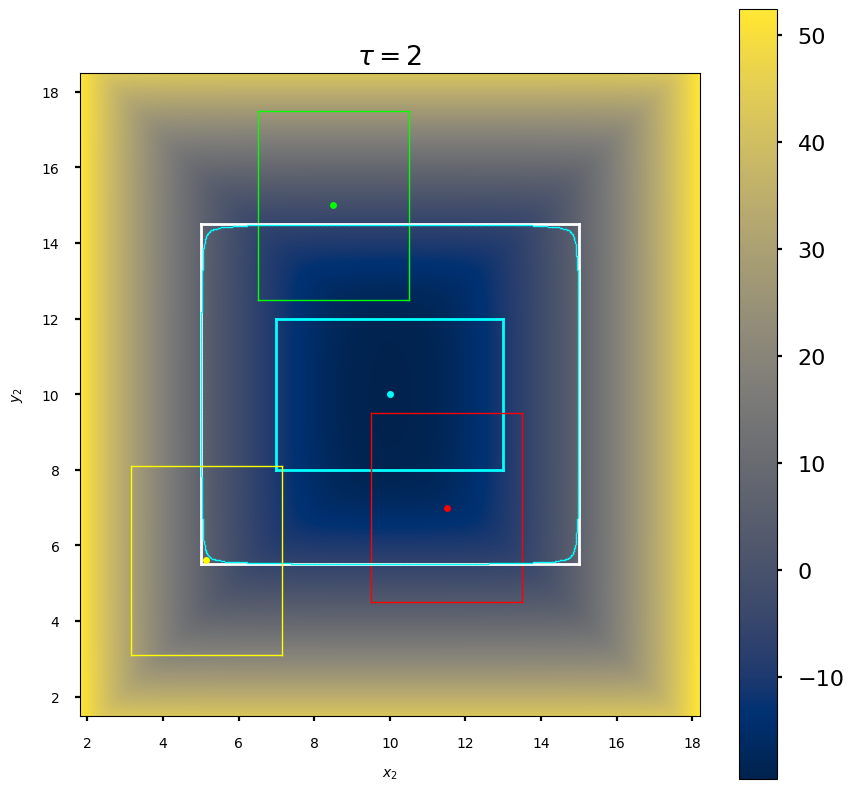

In [413]:
for tau in [15, 10, 5, 2]:
    plot_regions(x1, y1, w1, h1, w2, h2, tau)

## Effective rectangle

In [414]:
def point_inside(x, y, w, h, xp, yp, tau):
    """Indicates whether the point (xp, yp) is inside the rectangle with center (x,y) and dimensions (w,h)"""
    out_x = 4*((x-xp)**2) - w*w
    out_y = 4*((y-yp)**2) - h*h
    result = fmax(out_x, out_y, tau)
    # print(f'{xp} {yp} outx={out_x} outy={out_y} max={result} {result <= 0}')
    return result <= 0

In [415]:
def plot_effective_rectangle(x, y, w, h, taus: list[float]):
    samples = 1000
    margin = 0.02
    n = len(taus)
    xspace = np.linspace(x-w/2-margin, x+w/2+margin, num=samples)
    yspace = np.linspace(y-h/2-margin, y+h/2+margin, num=samples)
    
    # Create the figure
    fig, ax = plt.subplots(1,n)
    cmap = clr.ListedColormap(['white', 'grey'])
    #set_fontsize(ax, 10)
    plt.axis('off')
    
    # fig, ax = plt.subplots(figsize=(10, 10))
    for i, tau in enumerate(taus):
        zz = np.array([[point_inside(x, y, w, h, xp, yp, tau)
                    for xp in xspace] for yp in yspace])
        ax[i].axis('off')
        cs = ax[i].imshow(zz, cmap=cmap,
                    extent=[np.min(xspace), np.max(xspace), np.min(yspace), np.max(yspace)])
        ax[i].set_title(f'w={w}, h={h}, '+r'$\tau=$'+str(tau), size=12)
        plot_rectangle(ax[i], x, y, w, h, 'red', False, 1)
        

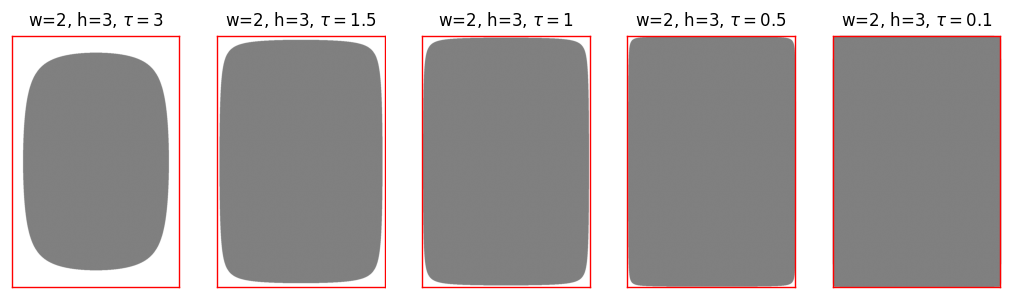

In [417]:
x, y, w, h = 1, 2, 2, 3
taus = [3, 1.5, 1, 0.5, 0.1]
plot_effective_rectangle(x, y, w, h, taus)

## Conclusions

The use of an approximate smooth max function to model rectangle overlapping allows to explore a large space of solutions. There is a trade-off:
* Small values of $\tau$ provide quasi-legal solutions (very small overlaps), at the expense of restricting the exploration space, since it may become difficult to overpass rectangles to find better solutions when using gradient methods. The exploration may be trapped into a local minimum earlier.
* Big values of $\tau$ tolerate illegal solutions and the exploration of a larger space of solutions. However the solutions may be highly illegal.

This trade-off suggests that $\tau$ could be used as a dynamic hyperparameter. Initially, big values of $\tau$ may tolerate moderate overlaps that would enable a larger exploration of relative positions. As the optimization evolves, $\tau$ could be reduced to restrict the exploration space and converge towards legal solutions.